# **CNN** *Pytorch*

### **Imports...**

In [9]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

### **GPU/MPS/CPU...**

In [10]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [11]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x
print(
    f"~~~~~~~~~ \n"
    f"CNN ready! \n"
    f"~~~~~~~~~")

~~~~~~~~~ 
CNN ready! 
~~~~~~~~~


### **Hyperparamethers...**

In [12]:
num_classes = 26 
learning_rate = 0.005
batch_size = 128
num_epochs = 50
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [13]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

train_dataset = datasets.EMNIST(root='emnist-letters-train',split='letters', train=True, download=True, transform=train_transform(), target_transform=lambda y: y-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [14]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [16]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # =======================
    # TRAINING
    # =======================
    model.train()
    train_loss_total = 0.0
    train_correct = 0
    train_samples = 0

    for data, targets in tqdm(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)

        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)

        # Loss (sum for whole epoch)
        train_loss_total += loss.item() * batch_size

        # Accuracy
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_samples += batch_size

    train_loss = train_loss_total / train_samples
    train_acc = 100.0 * train_correct / train_samples

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # =======================
    # EVALUATION
    # =======================
    model.eval()
    test_loss_total = 0.0
    test_correct = 0
    test_samples = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)

            batch_size = y.size(0)

            # Loss (sum for whole epoch)
            test_loss_total += loss.item() * batch_size

            # Accuracy
            _, preds = scores.max(1)
            test_correct += (preds == y).sum().item()
            test_samples += batch_size

    test_loss = test_loss_total / test_samples
    test_acc = 100.0 * test_correct / test_samples

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # =======================
    # LOGGING
    # =======================
    print(
        f"TRAIN | acc: {train_acc:.2f}% | loss: {train_loss:.4f}   "
        f"TEST | acc: {test_acc:.2f}% | loss: {test_loss:.4f}"
    )

    # Scheduler step
    scheduler.step()

print("===== Training Complete =====")
print(f"Final Train Acc: {train_accuracies[-1]:.2f}%")
print(f"Final Test Acc: {test_accuracies[-1]:.2f}%")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")


Epoch [1/50]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.92it/s]


TRAIN | acc: 55.33% | loss: 1.4011   TEST | acc: 87.95% | loss: 0.3812
Epoch [2/50]
Learning rate: 0.004995


100%|██████████| 975/975 [00:36<00:00, 26.92it/s]


TRAIN | acc: 80.52% | loss: 0.6192   TEST | acc: 91.49% | loss: 0.2492
Epoch [3/50]
Learning rate: 0.004980


100%|██████████| 975/975 [00:35<00:00, 27.29it/s]


TRAIN | acc: 84.65% | loss: 0.4858   TEST | acc: 92.40% | loss: 0.2312
Epoch [4/50]
Learning rate: 0.004956


100%|██████████| 975/975 [00:36<00:00, 26.99it/s]


TRAIN | acc: 86.39% | loss: 0.4293   TEST | acc: 93.26% | loss: 0.2057
Epoch [5/50]
Learning rate: 0.004921


100%|██████████| 975/975 [00:35<00:00, 27.12it/s]


TRAIN | acc: 87.63% | loss: 0.3923   TEST | acc: 93.53% | loss: 0.1955
Epoch [6/50]
Learning rate: 0.004878


100%|██████████| 975/975 [00:35<00:00, 27.16it/s]


TRAIN | acc: 88.22% | loss: 0.3704   TEST | acc: 93.56% | loss: 0.1966
Epoch [7/50]
Learning rate: 0.004824


100%|██████████| 975/975 [00:35<00:00, 27.33it/s]


TRAIN | acc: 88.81% | loss: 0.3538   TEST | acc: 93.76% | loss: 0.1884
Epoch [8/50]
Learning rate: 0.004762


100%|██████████| 975/975 [00:37<00:00, 26.29it/s]


TRAIN | acc: 89.28% | loss: 0.3390   TEST | acc: 93.76% | loss: 0.1867
Epoch [9/50]
Learning rate: 0.004691


100%|██████████| 975/975 [00:35<00:00, 27.43it/s]


TRAIN | acc: 89.37% | loss: 0.3332   TEST | acc: 93.69% | loss: 0.1830
Epoch [10/50]
Learning rate: 0.004611


100%|██████████| 975/975 [00:36<00:00, 26.90it/s]


TRAIN | acc: 89.73% | loss: 0.3212   TEST | acc: 93.77% | loss: 0.1832
Epoch [11/50]
Learning rate: 0.004523


100%|██████████| 975/975 [00:35<00:00, 27.57it/s]


TRAIN | acc: 89.96% | loss: 0.3119   TEST | acc: 94.24% | loss: 0.1791
Epoch [12/50]
Learning rate: 0.004426


100%|██████████| 975/975 [00:35<00:00, 27.40it/s]


TRAIN | acc: 90.25% | loss: 0.3075   TEST | acc: 94.09% | loss: 0.1785
Epoch [13/50]
Learning rate: 0.004322


100%|██████████| 975/975 [00:35<00:00, 27.49it/s]


TRAIN | acc: 90.44% | loss: 0.2981   TEST | acc: 94.11% | loss: 0.1767
Epoch [14/50]
Learning rate: 0.004211


100%|██████████| 975/975 [00:34<00:00, 28.05it/s]


TRAIN | acc: 90.57% | loss: 0.2954   TEST | acc: 94.42% | loss: 0.1704
Epoch [15/50]
Learning rate: 0.004094


100%|██████████| 975/975 [00:33<00:00, 28.89it/s]


TRAIN | acc: 90.87% | loss: 0.2878   TEST | acc: 94.32% | loss: 0.1782
Epoch [16/50]
Learning rate: 0.003969


100%|██████████| 975/975 [00:35<00:00, 27.47it/s]


TRAIN | acc: 90.93% | loss: 0.2864   TEST | acc: 94.24% | loss: 0.1787
Epoch [17/50]
Learning rate: 0.003840


100%|██████████| 975/975 [00:35<00:00, 27.56it/s]


TRAIN | acc: 91.20% | loss: 0.2757   TEST | acc: 94.17% | loss: 0.1701
Epoch [18/50]
Learning rate: 0.003704


100%|██████████| 975/975 [00:35<00:00, 27.46it/s]


TRAIN | acc: 91.38% | loss: 0.2688   TEST | acc: 94.52% | loss: 0.1697
Epoch [19/50]
Learning rate: 0.003564


100%|██████████| 975/975 [00:35<00:00, 27.57it/s]


TRAIN | acc: 91.37% | loss: 0.2671   TEST | acc: 94.52% | loss: 0.1633
Epoch [20/50]
Learning rate: 0.003420


100%|██████████| 975/975 [00:35<00:00, 27.37it/s]


TRAIN | acc: 91.47% | loss: 0.2659   TEST | acc: 94.64% | loss: 0.1592
Epoch [21/50]
Learning rate: 0.003273


100%|██████████| 975/975 [00:35<00:00, 27.29it/s]


TRAIN | acc: 91.62% | loss: 0.2623   TEST | acc: 94.46% | loss: 0.1656
Epoch [22/50]
Learning rate: 0.003122


100%|██████████| 975/975 [00:35<00:00, 27.57it/s]


TRAIN | acc: 91.89% | loss: 0.2528   TEST | acc: 94.52% | loss: 0.1667
Epoch [23/50]
Learning rate: 0.002968


100%|██████████| 975/975 [00:35<00:00, 27.27it/s]


TRAIN | acc: 91.79% | loss: 0.2540   TEST | acc: 94.64% | loss: 0.1600
Epoch [24/50]
Learning rate: 0.002813


100%|██████████| 975/975 [00:44<00:00, 21.75it/s]


TRAIN | acc: 92.02% | loss: 0.2480   TEST | acc: 94.50% | loss: 0.1606
Epoch [25/50]
Learning rate: 0.002657


100%|██████████| 975/975 [00:40<00:00, 24.34it/s]


TRAIN | acc: 92.01% | loss: 0.2487   TEST | acc: 94.53% | loss: 0.1634
Epoch [26/50]
Learning rate: 0.002500


100%|██████████| 975/975 [00:35<00:00, 27.47it/s]


TRAIN | acc: 92.21% | loss: 0.2422   TEST | acc: 94.73% | loss: 0.1584
Epoch [27/50]
Learning rate: 0.002343


100%|██████████| 975/975 [00:35<00:00, 27.35it/s]


TRAIN | acc: 92.27% | loss: 0.2369   TEST | acc: 94.62% | loss: 0.1662
Epoch [28/50]
Learning rate: 0.002187


100%|██████████| 975/975 [00:35<00:00, 27.82it/s]


TRAIN | acc: 92.23% | loss: 0.2377   TEST | acc: 94.73% | loss: 0.1593
Epoch [29/50]
Learning rate: 0.002032


100%|██████████| 975/975 [00:35<00:00, 27.58it/s]


TRAIN | acc: 92.29% | loss: 0.2340   TEST | acc: 94.61% | loss: 0.1598
Epoch [30/50]
Learning rate: 0.001878


100%|██████████| 975/975 [00:35<00:00, 27.54it/s]


TRAIN | acc: 92.49% | loss: 0.2323   TEST | acc: 94.70% | loss: 0.1578
Epoch [31/50]
Learning rate: 0.001727


100%|██████████| 975/975 [00:35<00:00, 27.55it/s]


TRAIN | acc: 92.67% | loss: 0.2263   TEST | acc: 94.66% | loss: 0.1593
Epoch [32/50]
Learning rate: 0.001580


100%|██████████| 975/975 [00:35<00:00, 27.55it/s]


TRAIN | acc: 92.63% | loss: 0.2248   TEST | acc: 94.77% | loss: 0.1569
Epoch [33/50]
Learning rate: 0.001436


100%|██████████| 975/975 [00:35<00:00, 27.53it/s]


TRAIN | acc: 92.78% | loss: 0.2244   TEST | acc: 94.78% | loss: 0.1560
Epoch [34/50]
Learning rate: 0.001296


100%|██████████| 975/975 [00:36<00:00, 26.69it/s]


TRAIN | acc: 92.74% | loss: 0.2221   TEST | acc: 94.88% | loss: 0.1553
Epoch [35/50]
Learning rate: 0.001160


100%|██████████| 975/975 [00:35<00:00, 27.70it/s]


TRAIN | acc: 92.85% | loss: 0.2188   TEST | acc: 94.87% | loss: 0.1565
Epoch [36/50]
Learning rate: 0.001031


100%|██████████| 975/975 [00:35<00:00, 27.70it/s]


TRAIN | acc: 93.06% | loss: 0.2141   TEST | acc: 94.91% | loss: 0.1573
Epoch [37/50]
Learning rate: 0.000906


100%|██████████| 975/975 [00:35<00:00, 27.60it/s]


TRAIN | acc: 93.02% | loss: 0.2145   TEST | acc: 94.95% | loss: 0.1554
Epoch [38/50]
Learning rate: 0.000789


100%|██████████| 975/975 [00:35<00:00, 27.69it/s]


TRAIN | acc: 93.09% | loss: 0.2128   TEST | acc: 94.96% | loss: 0.1533
Epoch [39/50]
Learning rate: 0.000678


100%|██████████| 975/975 [00:35<00:00, 27.75it/s]


TRAIN | acc: 93.21% | loss: 0.2096   TEST | acc: 94.84% | loss: 0.1552
Epoch [40/50]
Learning rate: 0.000574


100%|██████████| 975/975 [00:35<00:00, 27.61it/s]


TRAIN | acc: 93.19% | loss: 0.2065   TEST | acc: 94.91% | loss: 0.1544
Epoch [41/50]
Learning rate: 0.000477


100%|██████████| 975/975 [00:35<00:00, 27.69it/s]


TRAIN | acc: 93.23% | loss: 0.2057   TEST | acc: 94.98% | loss: 0.1546
Epoch [42/50]
Learning rate: 0.000389


100%|██████████| 975/975 [00:36<00:00, 26.83it/s]


TRAIN | acc: 93.29% | loss: 0.2064   TEST | acc: 95.03% | loss: 0.1540
Epoch [43/50]
Learning rate: 0.000309


100%|██████████| 975/975 [00:35<00:00, 27.73it/s]


TRAIN | acc: 93.27% | loss: 0.2038   TEST | acc: 94.99% | loss: 0.1523
Epoch [44/50]
Learning rate: 0.000238


100%|██████████| 975/975 [00:35<00:00, 27.83it/s]


TRAIN | acc: 93.31% | loss: 0.2049   TEST | acc: 95.02% | loss: 0.1525
Epoch [45/50]
Learning rate: 0.000176


100%|██████████| 975/975 [00:35<00:00, 27.53it/s]


TRAIN | acc: 93.37% | loss: 0.2039   TEST | acc: 95.04% | loss: 0.1524
Epoch [46/50]
Learning rate: 0.000122


100%|██████████| 975/975 [00:35<00:00, 27.47it/s]


TRAIN | acc: 93.35% | loss: 0.2026   TEST | acc: 95.00% | loss: 0.1521
Epoch [47/50]
Learning rate: 0.000079


100%|██████████| 975/975 [00:35<00:00, 27.64it/s]


TRAIN | acc: 93.36% | loss: 0.2036   TEST | acc: 95.06% | loss: 0.1521
Epoch [48/50]
Learning rate: 0.000044


100%|██████████| 975/975 [00:35<00:00, 27.53it/s]


TRAIN | acc: 93.36% | loss: 0.2016   TEST | acc: 95.05% | loss: 0.1519
Epoch [49/50]
Learning rate: 0.000020


100%|██████████| 975/975 [00:35<00:00, 27.73it/s]


TRAIN | acc: 93.47% | loss: 0.2003   TEST | acc: 95.04% | loss: 0.1525
Epoch [50/50]
Learning rate: 0.000005


100%|██████████| 975/975 [00:39<00:00, 24.40it/s]


TRAIN | acc: 93.43% | loss: 0.2027   TEST | acc: 95.02% | loss: 0.1527
===== Training Complete =====
Final Train Acc: 93.43%
Final Test Acc: 95.02%
Final Train Loss: 0.2027
Final Test Loss: 0.1527


### **Plotting...**

In [21]:
def plot_stats(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = test_acc.index(max(test_acc))
    best_acc = test_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, test_acc, label="Test Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. test accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, test_loss, label="Test Loss", color='sienna')
    ax2.set_title('Train vs. test loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_results_plot.png")
    plt.tight_layout()
    plt.show()

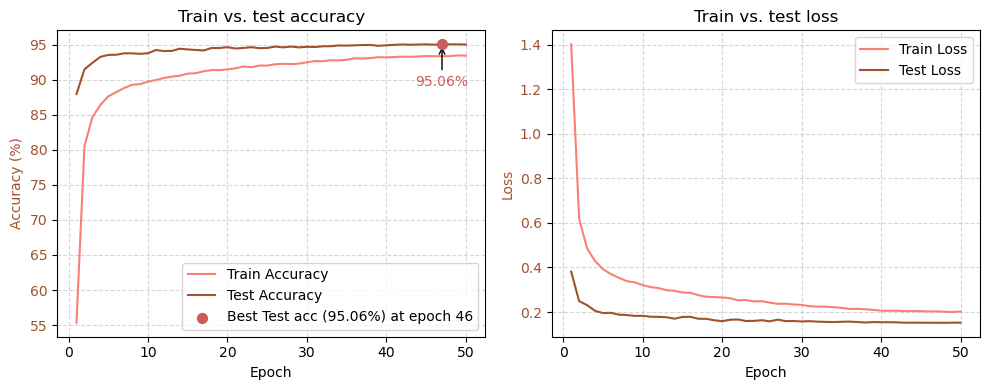

In [22]:
plot_stats(
    train_accuracies, 
    test_accuracies, 
    train_losses, 
    test_losses
)

### **Save results in file...**

In [28]:
filename = "CNN_results.txt"  

with open(filename, "w") as f:
    f.write("Epoch, Train loss, Train acc, Test loss, Test acc\n")
    
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, " 
            f"{test_losses[i]:.4f}, "
            f"{test_accuracies[i]:.2f}%\n")

    f.write("\n" + "="*40 + "\n")
    f.write("Final Metrics\n")
    f.write(f"Final Train Loss:     {train_losses[-1]:.4f}\n")
    f.write(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%\n")
    f.write(f"Final Test Loss:      {test_losses[-1]:.4f}\n")
    f.write(f"Final Test Accuracy:  {test_accuracies[-1]:.2f}%\n")
    f.write("="*40 + "\n")

print(f"Resultater gemt i: {filename}")

Resultater gemt i: CNN_results.txt


### **Gem efter træning:**

In [ ]:
torch.save(model.state_dict(), "my_model_state_dict.pth")